In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import itertools

In [2]:
base_path = "C:/Users/tarek.chouaki/repos/github/tkchouaki/inclusive-cccam/outputs"
output_path = "C:/Users/tarek.chouaki/repos/github/tkchouaki/inclusive-cccam/plots"

probabilities = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
times = [120, 180, 240, 300]

index = index=pd.MultiIndex.from_tuples(itertools.product([int(p*100) for p in probabilities], times), names=["vulnerable_share", "vulnerable_time"])
rejection_rates = pd.DataFrame(index=index, columns=["vulnerable", "non vulnerable", "overall"])
wait_times = pd.DataFrame(index=index, columns=["vulnerable", "non vulnerable", "overall"])
detour_factors = pd.DataFrame(index=index, columns=["vulnerable", "non vulnerable", "overall"])

In [3]:
for p in probabilities:
    for t in times:
        if isinstance(p, int):
            scenario_dir = "output_{}.0_{}".format(p, t)
        else:
            scenario_dir = "output_{:.1}_{}".format(p, t)
        persons_path = os.path.join(base_path, scenario_dir, "output_persons.csv.gz")
        rejections_path = os.path.join(base_path, scenario_dir, "ITERS", "it.0", "0.drt_rejections_drt.csv")
        drt_legs_path = os.path.join(base_path, scenario_dir, "ITERS", "it.0", "0.drt_legs_drt.csv")

        found_all = os.path.isfile(persons_path) and os.path.isfile(rejections_path) and os.path.isfile(drt_legs_path) 
        if not found_all:
            print("{} not found".format(scenario_dir))
            continue
            
        df_persons = pd.read_csv(persons_path, sep=";")[["person",  "drtInteractionTime"]]
        df_rejections = pd.read_csv(rejections_path, sep=";")[["personIds"]].rename(columns={"personIds": "person"})
        df_rejections["rejected"] = 1

        df_drt_legs = pd.read_csv(drt_legs_path, sep=";")
        df_drt_legs["vulnerable"] = df_drt_legs["personId"].apply(lambda person_id: person_id in df_persons[df_persons["drtInteractionTime"]>60]["person"].values)
        df_drt_legs["detourFactor"] = df_drt_legs["travelDistance_m"] / df_drt_legs["directTravelDistance_m"] 
        df_performance = df_drt_legs[["vulnerable", "waitTime", "detourFactor"]].groupby("vulnerable").agg("mean")

        if False in df_performance.index:
            wait_times.loc[(int(p*100), t), "non vulnerable"] = df_performance.loc[False, "waitTime"]
            detour_factors.loc[(int(p*100), t), "non vulnerable"] = df_performance.loc[False, "detourFactor"]
        if True in df_performance.index:
            wait_times.loc[(int(p*100), t), "vulnerable"] = df_performance.loc[True, "waitTime"]
            detour_factors.loc[(int(p*100), t), "vulnerable"] = df_performance.loc[True, "detourFactor"]
        wait_times.loc[(int(p*100), t), "overall"] = df_drt_legs["waitTime"].mean()
        detour_factors.loc[(int(p*100), t), "overall"] = df_drt_legs["detourFactor"].mean()
    
        
        df_performed = df_drt_legs.copy()[["personId"]].rename(columns={"personId": "person"})
        df_performed["rejected"] = 0

        df = pd.concat([df_performed, df_rejections]).merge(df_persons, on="person")
        df = df.groupby("drtInteractionTime").agg({"person": "count", "rejected": "mean"})
        
        if t in df.index:
            rejection_rates.loc[(int(p*100), t), "vulnerable"] = df.loc[float(t), "rejected"] * 100
        if 60.0 in df.index:
            rejection_rates.loc[(int(p*100), t), "non vulnerable"] = df.loc[60.0, "rejected"] * 100
        rejection_rates.loc[(int(p*100), t), "overall"] = 100 * len(df_rejections) / (len(df_performed) + len(df_rejections))
        
        plt.show()

In [4]:
df = rejection_rates.reset_index()
df = df[df["vulnerable_time"] == 120].drop(columns="vulnerable_time").set_index("vulnerable_share")
df

,vulnerable,non vulnerable,overall
vulnerable_share,,,
0,NaN,54.484007,54.484007
10,72.201722,53.673224,55.49119
20,68.367347,51.798126,55.130372
30,68.124006,50.67591,55.973932
40,67.650566,50.212939,57.272179
50,66.273187,49.455601,57.882665
60,64.190553,49.143887,58.143185
70,63.817269,45.588822,58.305167
80,62.286664,44.891827,58.792999


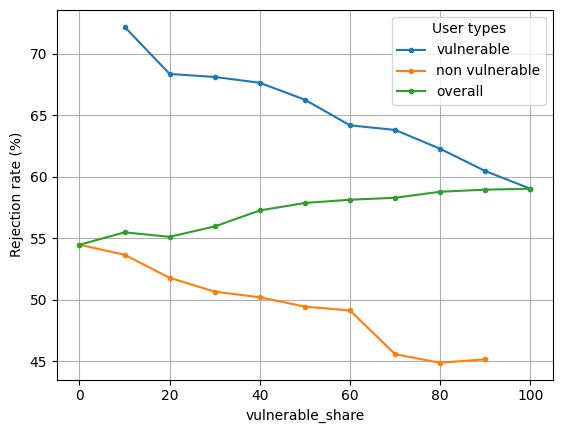

In [5]:
df.plot(grid=True, marker=".", ylabel="Rejection rate (%)").legend(title="User types")
fig_path = os.path.join(output_path, "rejections.pdf")
plt.savefig(fig_path, bbox_inches="tight")
plt.show()

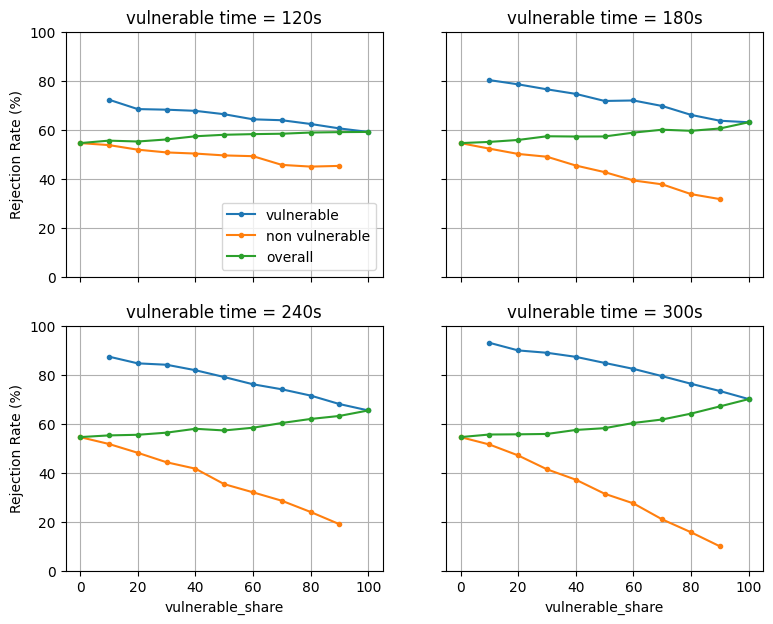

In [6]:
df = rejection_rates.reset_index()
fig, ax = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=True)
i = 0
for t in times:
    row = i // 2
    column = i%2
    df_plot = df[df["vulnerable_time"] == t].drop(columns="vulnerable_time").set_index("vulnerable_share")
    plot = df_plot.plot(ax=ax[row, column], grid=True, marker=".", legend=False, ylabel="Rejection Rate (%)", ylim=(0, 100), title="vulnerable time = {}s".format(t))
    if i == 0:
        plot.legend(loc="lower right")
    i+=1
plt.show()

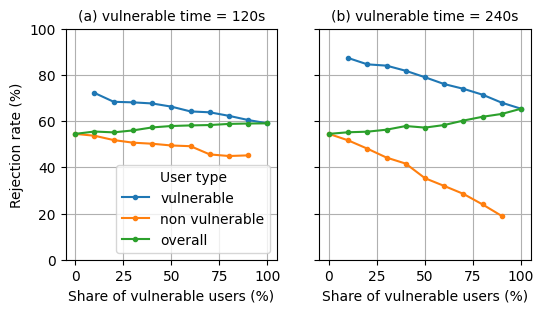

In [7]:
df = rejection_rates.reset_index()
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
i = 0
labels = ["(a)", "(b)"]
for t in [120, 240]:
    row = i %2
    df_plot = df[df["vulnerable_time"] == t].drop(columns="vulnerable_time").set_index("vulnerable_share")
    title = "{} vulnerable time = {}s".format(labels[i], t)
    plot = df_plot.plot(ax=ax[row], grid=True, marker=".", legend=False, ylabel="Rejection rate (%)", xlabel="Share of vulnerable users (%)", ylim=(0, 100))
    plot.set_title(title, fontsize = 10)
    if i == 0:
        plot.legend(title="User type", loc="lower right")
    i+=1
fig_path = os.path.join(output_path, "rejections.pdf")
plt.savefig(fig_path, bbox_inches="tight")
plt.show()

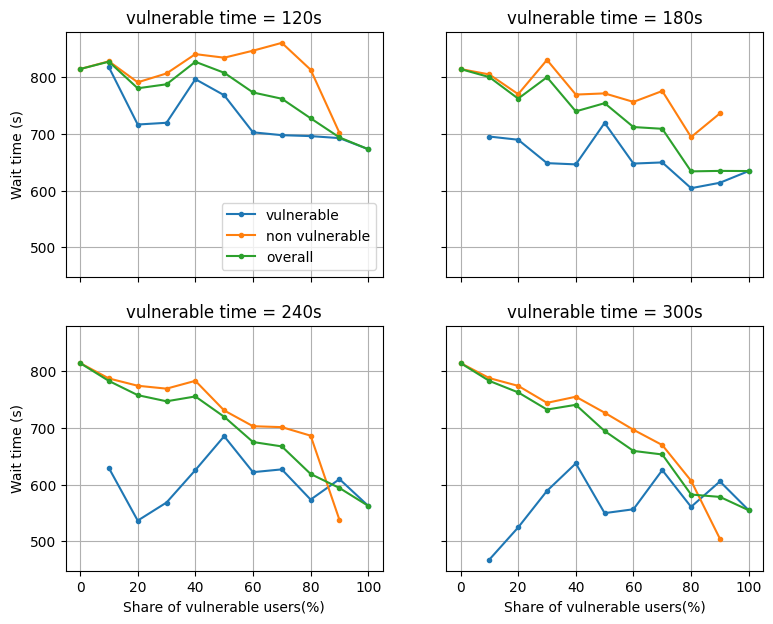

In [8]:
df = wait_times.reset_index()
fig, ax = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=True)
i = 0
for t in times:
    row = i // 2
    column = i%2
    df_plot = df[df["vulnerable_time"] == t].drop(columns="vulnerable_time").set_index("vulnerable_share")
    plot = df_plot.plot(ax=ax[row, column], grid=True, marker=".", legend=False, ylabel="Wait time (s)", xlabel="Share of vulnerable users(%)", title="vulnerable time = {}s".format(t))
    if i == 0:
        plot.legend(loc="lower right")
    i+=1
plt.show()

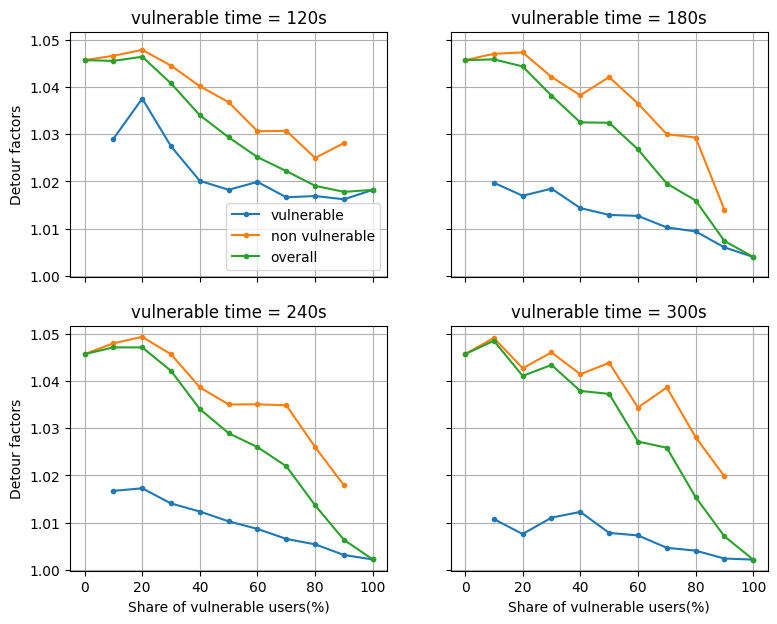

In [9]:
df = detour_factors.reset_index()
fig, ax = plt.subplots(2, 2, figsize=(9, 7), sharex=True, sharey=True)
i = 0
for t in times:
    row = i // 2
    column = i%2
    df_plot = df[df["vulnerable_time"] == t].drop(columns="vulnerable_time").set_index("vulnerable_share")
    plot = df_plot.plot(ax=ax[row, column], grid=True, marker=".", legend=False, ylabel="Detour factors", xlabel="Share of vulnerable users(%)", title="vulnerable time = {}s".format(t))
    if i == 0:
        plot.legend(loc="lower right")
    i+=1
plt.show()